In [105]:
import pandas as pd
import torch
import numpy as np
import plotly.graph_objects as go
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tqdm.notebook import tqdm
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb


In [97]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

def format_row_as_string(row):
    row_string = f"Tweet ID: {row['id']}, "
    row_string += f"Keyword: {row['keyword'] if pd.notnull(row['keyword']) else 'N/A'}, "
    row_string += f"Location: {row['location'] if pd.notnull(row['location']) else 'N/A'}, "
    row_string += f"Text: {row['text']}."
    return row_string

def load_embeddings(df, embeddings):
    assert len(df) == len(embeddings), "The number of rows in the DataFrame and the number of encoded vectors must match."
    for i in range(embeddings.shape[1]):
        df[f'encoded_dim_{i}'] = embeddings[:, i]
    df['encoded_vector'] = list(embeddings)

encoded_vectors = np.load('data/encoded_train.npy')
encoded_vectors_test = np.load('data/encoded_test.npy')

load_embeddings(df_train, encoded_vectors)
load_embeddings(df_test, encoded_vectors_test)
df_train.head()

embeddings = np.stack(df_train['encoded_vector'].values)
embeddings_test = np.stack(df_test['encoded_vector'].values)


C:\Users\elian\AppData\Local\Temp\ipykernel_25920\2403841762.py:14: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\elian\AppData\Local\Temp\ipykernel_25920\2403841762.py:14: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\elian\AppData\Local\Temp\ipykernel_25920\2403841762.py:14: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragment

In [98]:
# PCA for 2D
pca = PCA(n_components=2)
embeddings_pca_2d = pca.fit_transform(embeddings)

# PCA for 3D
pca = PCA(n_components=3)
embeddings_pca_3d = pca.fit_transform(embeddings)

# t-SNE for 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_tsne_2d = tsne.fit_transform(embeddings)

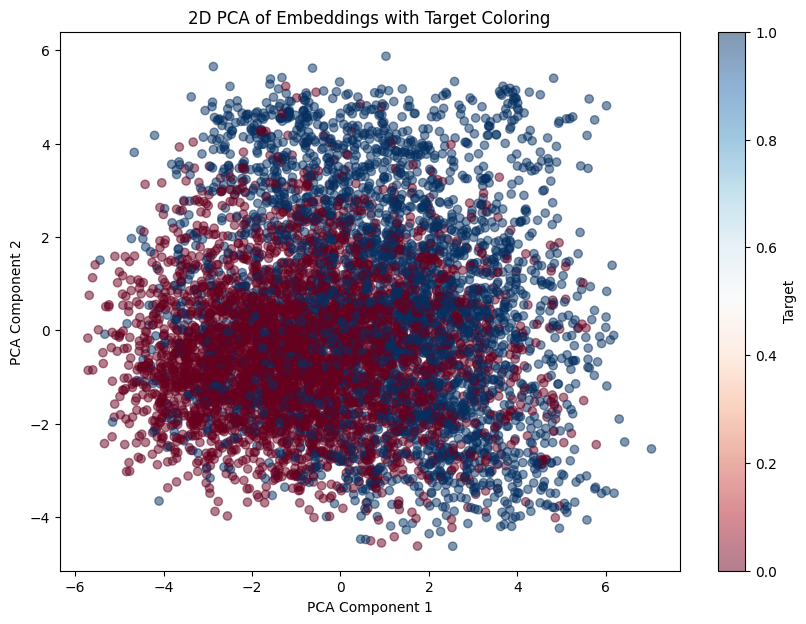

In [99]:
plt.figure(figsize=(10, 7))
plt.scatter(embeddings_pca_2d[:, 0], embeddings_pca_2d[:, 1], c=df_train['target'], cmap='RdBu', alpha=0.5)
plt.title('2D PCA of Embeddings with Target Coloring')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Target')
plt.show()


In [17]:
fig = go.Figure()

# Add points for target == 0
fig.add_trace(go.Scatter3d(
    x=embeddings_pca_3d[df_train['target'] == 0, 0],
    y=embeddings_pca_3d[df_train['target'] == 0, 1],
    z=embeddings_pca_3d[df_train['target'] == 0, 2],
    mode='markers',
    marker=dict(size=5, color='blue', opacity=0.5),
    name='Target 0'
))

# Add points for target == 1
fig.add_trace(go.Scatter3d(
    x=embeddings_pca_3d[df_train['target'] == 1, 0],
    y=embeddings_pca_3d[df_train['target'] == 1, 1],
    z=embeddings_pca_3d[df_train['target'] == 1, 2],
    mode='markers',
    marker=dict(size=5, color='red', opacity=0.5),
    name='Target 1'
))

# Update the layout
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis_title='PCA Component 1',
        yaxis_title='PCA Component 2',
        zaxis_title='PCA Component 3'
    )
)

fig.show()


In [84]:
import torch.nn as nn
import torch.nn.functional as F

class TweetClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetClassifier, self).__init__()
        # First hidden layer
        self.fc1 = nn.Linear(input_size, hidden_size)
        # Additional hidden layers
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        # Output layer for binary classification - single output unit
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.1, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.fc3(x)
        return x

# Assuming 'embeddings' is your feature matrix and 'targets' is your labels vector
X_train, X_test, y_train, y_test = train_test_split(embeddings, df_train['target'].values, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for data, target in train_loader:
    data, target = data.to(device), target.to(device)

num_zeros = (y_train == 0).sum().item()
num_ones = (y_train == 1).sum().item()
total = y_train.size(0)

proportion_zeros = num_zeros / total
proportion_ones = num_ones / total

print(f"Proportion of 0s: {proportion_zeros:.2f}")
print(f"Proportion of 1s: {proportion_ones:.2f}")


Proportion of 0s: 0.57
Proportion of 1s: 0.43


In [85]:
model = TweetClassifier(input_size=embeddings.shape[1], hidden_size=100, num_classes=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#criterion = nn.CrossEntropyLoss()

print(np.unique(y_train))

# Ensure y_train is a numpy array and contains integer labels
y_train_np = y_train.cpu().numpy() if isinstance(y_train, torch.Tensor) else y_train
y_train_np = y_train_np.astype(int)  # Ensure integer type

# Now compute class weights
unique_classes = np.unique(y_train_np)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_np)

# For binary classification with nn.BCEWithLogitsLoss, calculate the pos_weight parameter
pos_weight = class_weights[1] / class_weights[0]
pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float).to(device)

# Initialize the criterion with pos_weight
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)


# Training loop
num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        labels = labels.view(-1, 1) if labels.dim() == 1 else labels
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


[0. 1.]


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Loss: 0.4315
Epoch [2/100], Loss: 0.3534
Epoch [3/100], Loss: 0.4835
Epoch [4/100], Loss: 0.3837
Epoch [5/100], Loss: 0.4974
Epoch [6/100], Loss: 0.3699
Epoch [7/100], Loss: 0.5229
Epoch [8/100], Loss: 0.3838
Epoch [9/100], Loss: 0.4126
Epoch [10/100], Loss: 0.3142
Epoch [11/100], Loss: 0.1087
Epoch [12/100], Loss: 0.3144
Epoch [13/100], Loss: 0.1731
Epoch [14/100], Loss: 0.2149
Epoch [15/100], Loss: 0.5061
Epoch [16/100], Loss: 0.7835
Epoch [17/100], Loss: 0.3053
Epoch [18/100], Loss: 0.2671
Epoch [19/100], Loss: 0.2449
Epoch [20/100], Loss: 0.3347
Epoch [21/100], Loss: 0.0716
Epoch [22/100], Loss: 0.0287
Epoch [23/100], Loss: 0.1879
Epoch [24/100], Loss: 0.1473
Epoch [25/100], Loss: 0.0825
Epoch [26/100], Loss: 0.1854
Epoch [27/100], Loss: 0.0614
Epoch [28/100], Loss: 0.0902
Epoch [29/100], Loss: 0.1134
Epoch [30/100], Loss: 0.4082
Epoch [31/100], Loss: 0.0851
Epoch [32/100], Loss: 0.1663
Epoch [33/100], Loss: 0.1379
Epoch [34/100], Loss: 0.0947
Epoch [35/100], Loss: 0

In [87]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in tqdm(test_loader, desc='Evaluating'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test set: {100 * correct / total}%')



Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]

Accuracy of the model on the test set: 57.386736703873936%


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       874
         1.0       0.00      0.00      0.00       649

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg       0.33      0.57      0.42      1523



C:\Users\elian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\elian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\elian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

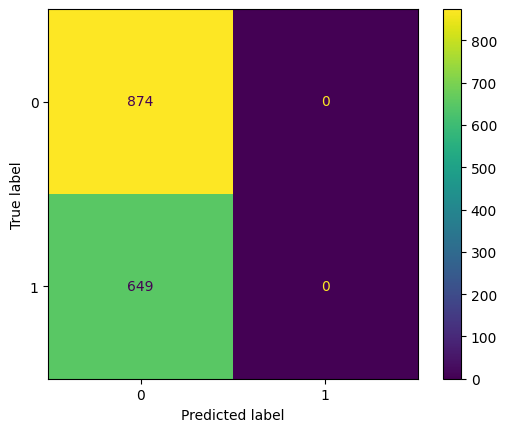

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Evaluating'):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
